In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data_dir = r'C:\Users\piyus\code-windows\Images'
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 12 classes.
Using 48 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 12 classes.
Using 12 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Abelmoschus esculentus', 'Abutilon indicum', 'Acacia rugata', 'Bixa orellana', 'Blepharis edulis', 'Bryophyllum pinnatum', 'Clerodendrum inerme', 'Cocccinia grandis', 'Colchicum luteum', 'Daphne oleoides', 'Datura metal', 'Derris ferruginea']


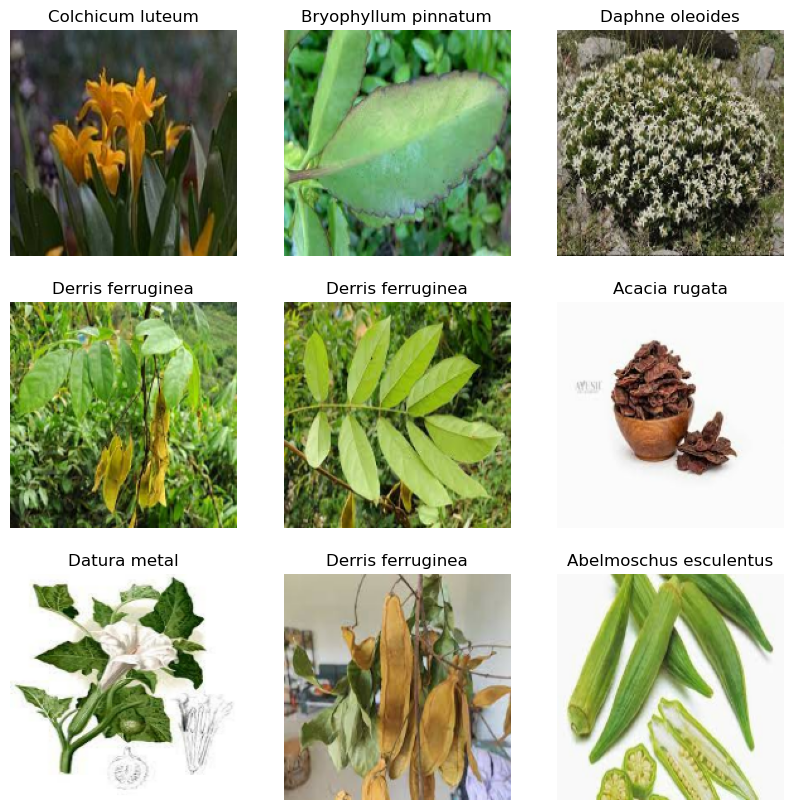

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9949055


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 1s 289ms/step - loss: 2.9858 - accuracy: 0.1042 - val_loss: 3.0078 - val_accuracy: 0.0833
Epoch 2/10
2/2 [==============================] - 0s 159ms/step - loss: 2.4037 - accuracy: 0.1667 - val_loss: 2.5111 - val_accuracy: 0.0833
Epoch 3/10
2/2 [==============================] - 0s 236ms/step - loss: 2.2060 - accuracy: 0.4583 - val_loss: 2.3965 - val_accuracy: 0.0833
Epoch 4/10
2/2 [==============================] - 0s 148ms/step - loss: 1.9956 - accuracy: 0.5208 - val_loss: 2.4180 - val_accuracy: 0.0833
Epoch 5/10
2/2 [==============================] - 0s 154ms/step - loss: 1.6169 - accuracy: 0.6667 - val_loss: 2.3577 - val_accuracy: 0.2500
Epoch 6/10
2/2 [==============================] - 0s 231ms/step - loss: 1.1847 - accuracy: 0.6458 - val_loss: 2.2847 - val_accuracy: 0.2500
Epoch 7/10
2/2 [==============================] - 0s 215ms/step - loss: 0.7707 - accuracy: 0.8958 - val_loss: 2.1788 - val_accuracy: 0.2500
Epoch 8/10
2/2 [====

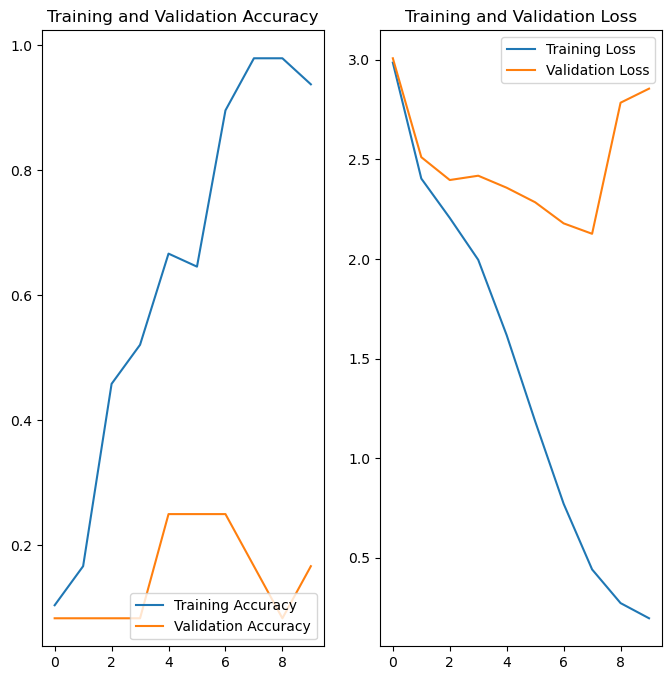

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

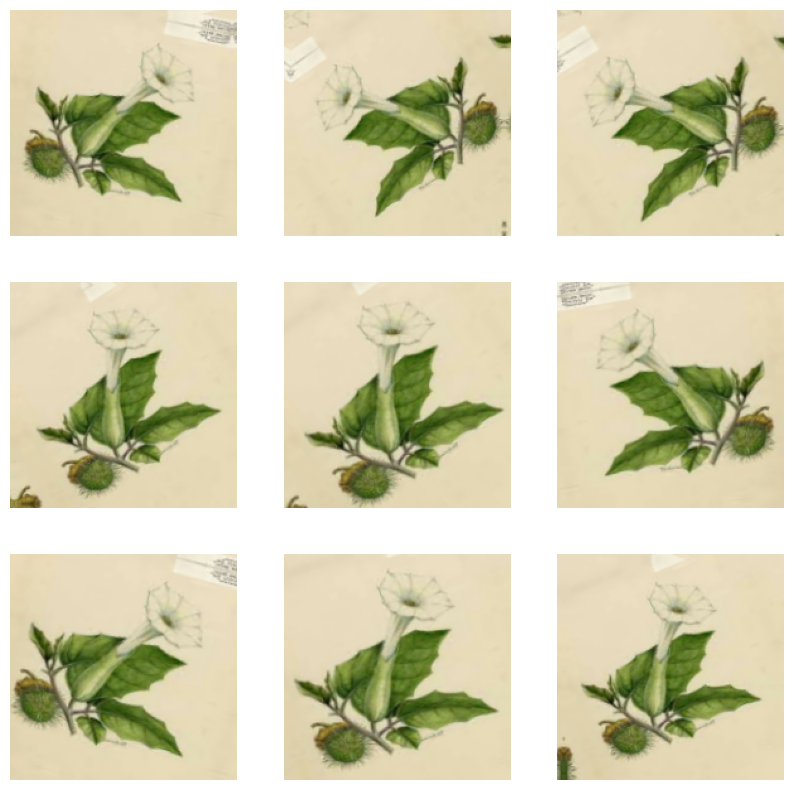

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/2 [==============================] - 2s 344ms/step - loss: 2.6101 - accuracy: 0.0625 - val_loss: 2.6957 - val_accuracy: 0.0833
Epoch 2/15
2/2 [==============================] - 0s 255ms/step - loss: 2.3274 - accuracy: 0.2500 - val_loss: 2.5613 - val_accuracy: 0.0000e+00
Epoch 3/15
2/2 [==============================] - 0s 155ms/step - loss: 2.2205 - accuracy: 0.2917 - val_loss: 2.4676 - val_accuracy: 0.0833
Epoch 4/15
2/2 [==============================] - 0s 166ms/step - loss: 2.0050 - accuracy: 0.3750 - val_loss: 2.4298 - val_accuracy: 0.1667
Epoch 5/15
2/2 [==============================] - 0s 154ms/step - loss: 1.7978 - accuracy: 0.4167 - val_loss: 2.7232 - val_accuracy: 0.0833
Epoch 6/15
2/2 [==============================] - 0s 241ms/step - loss: 1.7119 - accuracy: 0.4792 - val_loss: 2.8384 - val_accuracy: 0.1667
Epoch 7/15
2/2 [==============================] - 0s 291ms/step - loss: 1.4534 - accuracy: 0.4792 - val_loss: 2.6248 - val_accuracy: 0.1667
Epoch 8/15
2/2 [

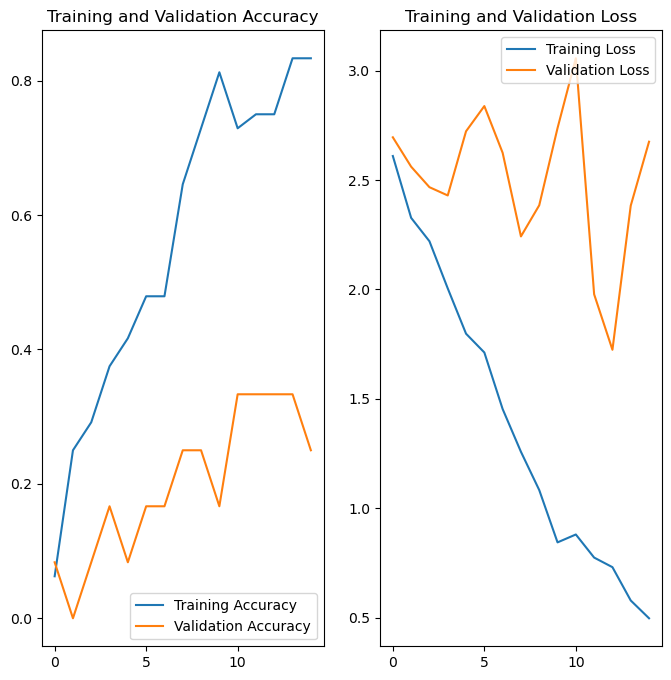

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()